In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
# Importing libaries

import opendatasets as od
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import math
import shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from PIL import Image
import torchvision
from torchvision import models
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim import SGD
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from timeit import default_timer as timer
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
import pandas as pd
import torchvision.models as models
from torchvision.transforms import ToTensor
from torch.optim import Adam
import time

In [ ]:
# Downloading Dataset from Kaggle - Kindly upload a kaggle API Key to enable download.

dataset_url = 'https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered'
od.download(dataset_url)

100%|██████████| 427M/427M [00:06<00:00, 73.3MB/s]


In [ ]:
# Removing unwanted file in folder

data_dir = './diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

# Iterate over the files in the directory
for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    # Check if the file has the desired extension
    if filename.endswith('.pkl'):
        # Remove the file
        os.remove(file_path)
        print(f'Removed file: {filename}')

print('All desired files removed successfully.')

Removed file: export.pkl
All desired files removed successfully.


In [ ]:
os.listdir(data_dir)

['No_DR', 'Mild', 'Severe', 'Moderate', 'Proliferate_DR']

In [ ]:
# Checking number of data available

for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

No_DR : 1805
Mild : 370
Severe : 193
Moderate : 999
Proliferate_DR : 295


In [ ]:
# Augmenting dataset to evenly distribute available data

import os
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define the data augmentation transforms
data_transforms = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(0, shear=20, scale=(0.8, 1.2))
])

# Define the path to the original dataset
data_dir = './diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

# Load the dataset using ImageFolder
dataset = ImageFolder(root=data_dir, transform=data_transforms)

# Define the number of images to sample from each class
num_images = 2000

# Create a dictionary to store the augmented images
augmented_images = {c: [] for c in dataset.classes}

# Iterate over the dataset and apply data augmentation techniques
for image, label in dataset:
    class_label = dataset.classes[label]
    if len(augmented_images[class_label]) < num_images:
        augmented_images[class_label].append(image)

        # If the number of augmented images for a class is less than num_images, augment the image and add it to the dictionary
        if len(augmented_images[class_label]) < num_images:
            augmented_images[class_label].append(data_transforms(image))

# Create a new folder to save the augmented images
new_data_dir = 'new_data_set'
os.makedirs(new_data_dir, exist_ok=True)

# Save the augmented images to the new folder
for c in dataset.classes:
    class_dir = os.path.join(new_data_dir, c)
    os.makedirs(class_dir, exist_ok=True)

    # Shuffle the augmented images for each class
    random.shuffle(augmented_images[c])

    # Save the first num_images augmented images for each class
    for i in range(num_images):
        if i < len(augmented_images[c]):
            image = augmented_images[c][i]
            filename = os.path.join(class_dir, f"{c}_{i}.jpg")
            image.save(filename)

    # If the number of augmented images for a class is still less than num_images,
    # randomly sample and save additional augmented images
    while len(augmented_images[c]) < num_images:
        random_image = random.choice(augmented_images[c])
        filename = os.path.join(class_dir, f"{c}_{len(augmented_images[c])}.jpg")
        random_image.save(filename)
        augmented_images[c].append(random_image)


In [ ]:
#Checking the new dataset count

import pandas as pd
# after augmenting the training dataset

data_dir =  '/content/new_data_set'

data = []
for cls in os.listdir(data_dir):
    subdir_path = os.path.join(data_dir, cls)
    file_count = len(os.listdir(subdir_path))
    data.append((cls, file_count))
df = pd.DataFrame(data, columns=['Class', 'Image Count'])
print(df)

dataset = ImageFolder(data_dir)
train_count = len(dataset)
print('Length of the dataset')
print('Length of Training Dataset:',  len(dataset))

            Class  Image Count
0           No_DR         2000
1            Mild         2000
2          Severe         2000
3        Moderate         2000
4  Proliferate_DR         2000
Length of the dataset
Length of Training Dataset: 10000


In [ ]:
dataset = ImageFolder(data_dir)

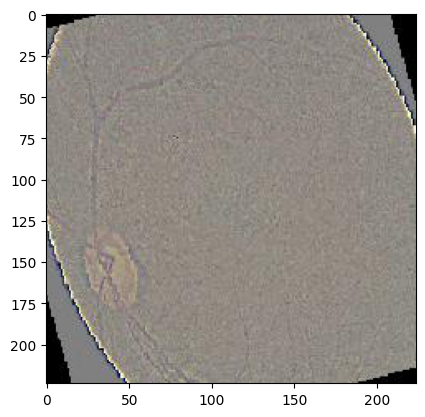

In [ ]:
# Viewing one of the images

img, label = dataset[9]

plt.imshow(img)

In [ ]:
# Creating function to split and store dataset

num_img = {}
for dir in os.listdir(data_dir):
  num_img[dir] = len(os.listdir(os.path.join(data_dir,dir)))

num_img.items()

def datafolder(folder, split):
    base_path = os.path.dirname(data_dir)
    folder_path = os.path.join(base_path, folder)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        for dir in os.listdir(data_dir):
            os.makedirs(os.path.join(folder_path, dir))
            for img in np.random.choice(a=os.listdir(os.path.join(data_dir, dir)), size=(math.floor(split * num_img[dir]) - 5), replace=False):
                O = os.path.join(data_dir, dir, img)
                D = os.path.join(folder_path, dir)
                shutil.copy(O, D)
                os.remove(O)
    else:
        print('the folder exists')

In [ ]:
# Splitting the dataset

datafolder('train', 0.6)
datafolder('val', 0.2)
datafolder('test', 0.2)

In [ ]:
train_dataset = '/content/train'
val_dataset = '/content/val'
test_dataset = '/content/test'

In [ ]:
# Checking amount of dataset in train folder

for cls in os.listdir(train_dataset):
    print(cls, ':', len(os.listdir(train_dataset + '/' + cls)))

train_ds = ImageFolder(train_dataset)
train_count = len(train_ds)
print('Lenght of Training Dataset:',  len(train_ds))

No_DR : 1195
Mild : 1195
Severe : 1195
Moderate : 1195
Proliferate_DR : 1195
Lenght of Training Dataset: 5975


In [ ]:
# Checking amount of dataset in validation folder

for cls in os.listdir(val_dataset):
    print(cls, ':', len(os.listdir(val_dataset + '/' + cls)))

valid_ds = ImageFolder(val_dataset)
valid_count = len(valid_ds)
print('Lenght of Validation Dataset:',  len(valid_ds))

No_DR : 395
Mild : 395
Severe : 395
Moderate : 395
Proliferate_DR : 395
Lenght of Validation Dataset: 1975


In [ ]:
# Checking amount of dataset in test folder

for cls in os.listdir(test_dataset):
    print(cls, ':', len(os.listdir(test_dataset + '/' + cls)))

test_ds = ImageFolder(test_dataset)
valid_count = len(test_ds)
print('Lenght of Test Dataset:',  len(test_ds))

No_DR : 395
Mild : 395
Severe : 395
Moderate : 395
Proliferate_DR : 395
Lenght of Test Dataset: 1975


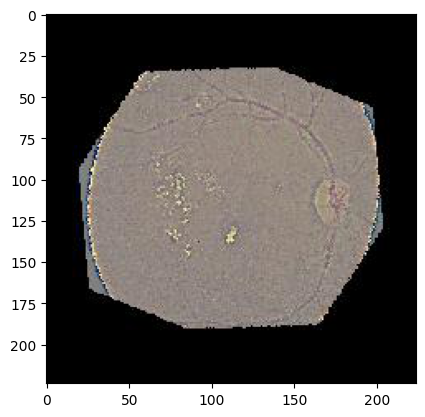

In [ ]:
# checking an image in the train dataset

img, label = train_ds[9]
plt.imshow(img)

In [ ]:
# Applying some transforms to the dataset to suit the format of the pre-trained model

mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]


train_ds = ImageFolder(train_dataset, tt.Compose([tt.RandomHorizontalFlip(),
                                                  tt.Resize((224, 224)),
                                                  tt.RandomRotation(45),
                                                  tt.ToTensor(),
                                                  tt.Normalize(mean=mean_values, std=std_values)]))

valid_ds = ImageFolder(val_dataset, tt.Compose([tt.RandomHorizontalFlip(),
                                                tt.Resize((224, 224)),
                                                tt.ToTensor(),
                                                tt.Normalize(mean=mean_values, std=std_values)]))

test_ds = ImageFolder(test_dataset, tt.Compose([tt.Resize((224, 224)),
                                                tt.ToTensor(),
                                                tt.Normalize(mean=mean_values, std=std_values)]))


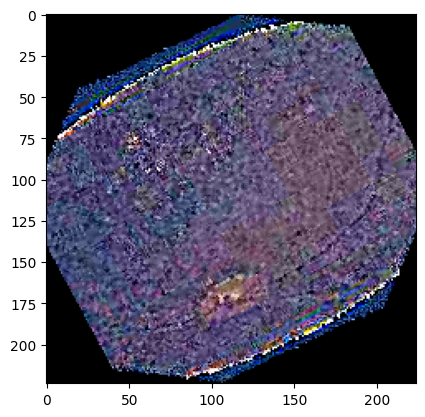

In [ ]:
'''image in index 12 after normalization'''

img, label = train_ds[12]
plt.imshow(img.permute((1, 2, 0)))

In [ ]:
# Creating a batch size which will be loaded using the 'dataloader' unto the GPU

batch_size = 32

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    shuffle=True,
                    num_workers=2)

test_dl = DataLoader(test_ds,
                    batch_size,
                    shuffle=True)

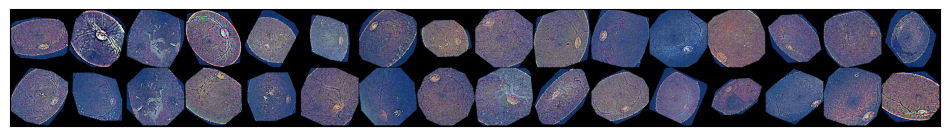

In [ ]:
# Displaying a 32-batch dataset from the data from training folder

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

In [ ]:
# Creating helper functions

"""this block helps choose the available accelerator"""

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Building the ResNet pre-trained model

class ResNet(nn.Module):
    def __init__(self, model_name, num_classes):
        super(ResNet, self).__init__()
        self.model_name = model_name
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Remove last layer (classification layer)
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, input):
        features = self.features(input)
        features = features.view(features.size(0), -1)
        output = self.fc(features)
        return output



In [ ]:
# Building the AlexNet pre-trained model

class AlexNet(nn.Module):
    def __init__(self, model_name, num_classes):
        super(AlexNet, self).__init__()
        self.model_name = model_name
        alexnet = models.alexnet(pretrained=True)
        self.features = nn.Sequential(*list(alexnet.features.children()))  # Use only the feature extraction layers

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))  # Adjust the dimensions of the feature maps
        self.fc = nn.Linear(256 * 6 * 6, num_classes)

    def forward(self, input):
        features = self.features(input)
        features = self.avgpool(features)
        features = features.view(features.size(0), -1)
        output = self.fc(features)
        return output


In [ ]:
# Building the VGG pre-trained model

class VGG(nn.Module):
    def __init__(self, model_name, num_classes):
        super(VGG, self).__init__()
        self.model_name = model_name
        vgg = models.vgg19(pretrained=True)
        self.features = nn.Sequential(*list(vgg.features.children()))  # Use only the feature extraction layers

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # Adjust the dimensions of the feature maps
        self.fc = nn.Linear(512 * 7 * 7, num_classes)

    def forward(self, input):
        features = self.features(input)
        features = self.avgpool(features)
        features = features.view(features.size(0), -1)
        output = self.fc(features)
        return output


In [ ]:
# Creating function to handle the training

def train_model(model, train_dl, valid_dl, num_epochs):
    train_losses = []
    train_accs = []
    valid_accs = []
    best_val_accuracy = 0.0
    best_model_state = None

    # num_classes = 5
    num_epochs = num_epochs

    # define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    loss_function=nn.CrossEntropyLoss()

    # Start the timer
    start_time = timer()

    model_name = model.model_name  # Get the model name from the ModelBuilder instance

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        train_accuracy = 0.0
        train_loss = 0.0
        train_count = len(train_ds)
        for i, (images, labels) in enumerate(train_dl):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().data * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            train_accuracy += int(torch.sum(prediction == labels.data))
        train_accuracy = train_accuracy / train_count
        train_loss = train_loss / train_count

        # Evaluation loop
        model.eval()
        valid_accuracy = 0.0
        valid_count = len(valid_ds)
        for i, (images, labels) in enumerate(valid_dl):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
            outputs = model(images)
            _, prediction = torch.max(outputs.data, 1)
            valid_accuracy += int(torch.sum(prediction == labels.data))
        valid_accuracy = valid_accuracy / valid_count


        # Append loss and accuracy values to lists
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        valid_accs.append(valid_accuracy)

        if valid_accuracy > best_val_accuracy:
          best_val_accuracy = valid_accuracy
          best_model_state = model.state_dict()

        torch.save(best_model_state, f'{model_name}_best_model.pth')

        # Print and plot loss and accuracy values for each epoch
        print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) +
              ' Train Accuracy: ' + str(train_accuracy) +
              ' Validation Accuracy: ' + str(valid_accuracy))


    # end training time
    end_time = timer()
    print()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    return train_losses, train_accs, valid_accs


In [ ]:
# Function to plot training curve

def plot_curves(train_losses, train_accs, valid_accs, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, valid_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to visualize predictions

import warnings

def visualize_predictions(model, data_loader, device, class_names, grid_x=5, grid_y=5):
    num_images = grid_x * grid_y
    plt.figure(figsize=(10, 10))
    model.eval()

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            if i >= num_images:
                break

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            img = images[0].permute(1, 2, 0).cpu().numpy()

            # Normalize image data
            img = (img - np.min(img)) / (np.max(img) - np.min(img))

            plt.subplot(grid_x, grid_y, i + 1)
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)
                plt.imshow(img)

            if preds[0].item() == labels[0].item():
                xlabel_color = 'green'
                ylabel_color = 'green'
            else:
                xlabel_color = 'red'
                ylabel_color = 'red'

            predicted_class = class_names[preds[0].item()]
            true_class = class_names[labels[0].item()]

            plt.xlabel(predicted_class, color=xlabel_color, fontsize=5)
            plt.ylabel(true_class, color=ylabel_color, fontsize=5)
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            plt.axis('on')

            if i == num_images - 1:
                break

    plt.tight_layout()
    plt.show()



In [ ]:
# Function to generate confusion matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def generate_confusion_matrix(model, data_loader, device, num_classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    confusion_mat = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return confusion_mat


In [ ]:
# Function to generate confusion matrix

def calculate_metrics(confusion_mat):
    tp = np.diag(confusion_mat)
    fp = np.sum(confusion_mat, axis=0) - tp
    fn = np.sum(confusion_mat, axis=1) - tp
    tn = np.sum(confusion_mat) - (tp + fp + fn)

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)

    return accuracy, precision, recall, f1_score


In [ ]:
# Function to display confusion matrix

def display_confusion_matrix(confusion_mat, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_mat, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(confusion_mat[i, j]), ha='center', va='center', color='white' if confusion_mat[i, j] > confusion_mat.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()



In [ ]:
# Function to display confusion matrix

def generate_confusion_matrix_with_metrics(model, data_loader, device, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        confusion_mat = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
        accuracy, precision, recall, f1_score = calculate_metrics(confusion_mat)

        print("Confusion Matrix:")
        print(confusion_mat)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-Score:", f1_score)


In [ ]:
# Identifying available device (CPU/GPU) and loading data unto it

device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
# variable to insert the number of classes and the number of Epoch to run

num_classes = 5
num_epochs = 50

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Train Loss: tensor(1.0121) Train Accuracy: 0.5730543933054393 Validation Accuracy: 0.6556962025316456
Epoch: 1 Train Loss: tensor(0.7782) Train Accuracy: 0.6970711297071129 Validation Accuracy: 0.7260759493670886
Epoch: 2 Train Loss: tensor(0.6221) Train Accuracy: 0.7663598326359833 Validation Accuracy: 0.7579746835443038
Epoch: 3 Train Loss: tensor(0.5189) Train Accuracy: 0.8115481171548117 Validation Accuracy: 0.7873417721518987
Epoch: 4 Train Loss: tensor(0.4451) Train Accuracy: 0.840836820083682 Validation Accuracy: 0.7432911392405064
Epoch: 5 Train Loss: tensor(0.3667) Train Accuracy: 0.8671129707112971 Validation Accuracy: 0.8065822784810126
Epoch: 6 Train Loss: tensor(0.3124) Train Accuracy: 0.8868619246861925 Validation Accuracy: 0.84
Epoch: 7 Train Loss: tensor(0.3169) Train Accuracy: 0.8835146443514644 Validation Accuracy: 0.8329113924050633
Epoch: 8 Train Loss: tensor(0.2628) Train Accuracy: 0.9072803347280335 Validation Accuracy: 0.8784810126582279
Epoch: 9 Train L

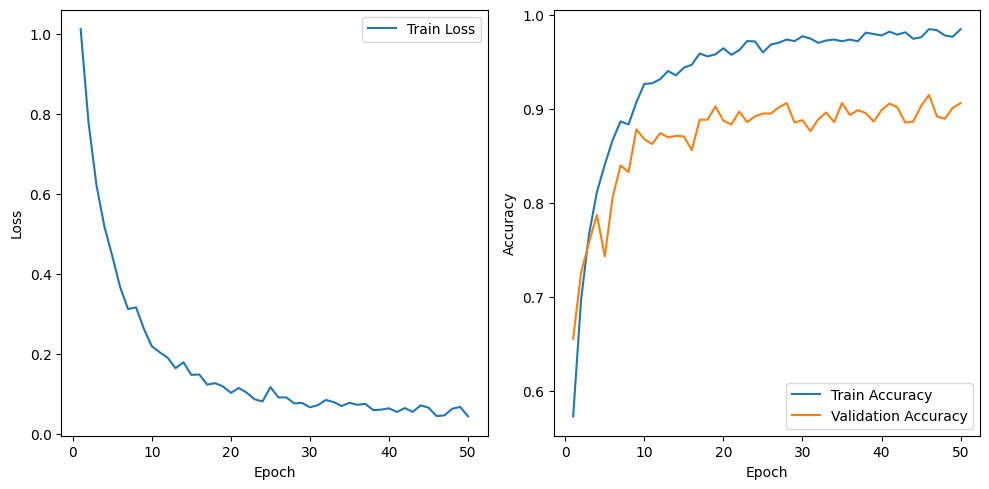

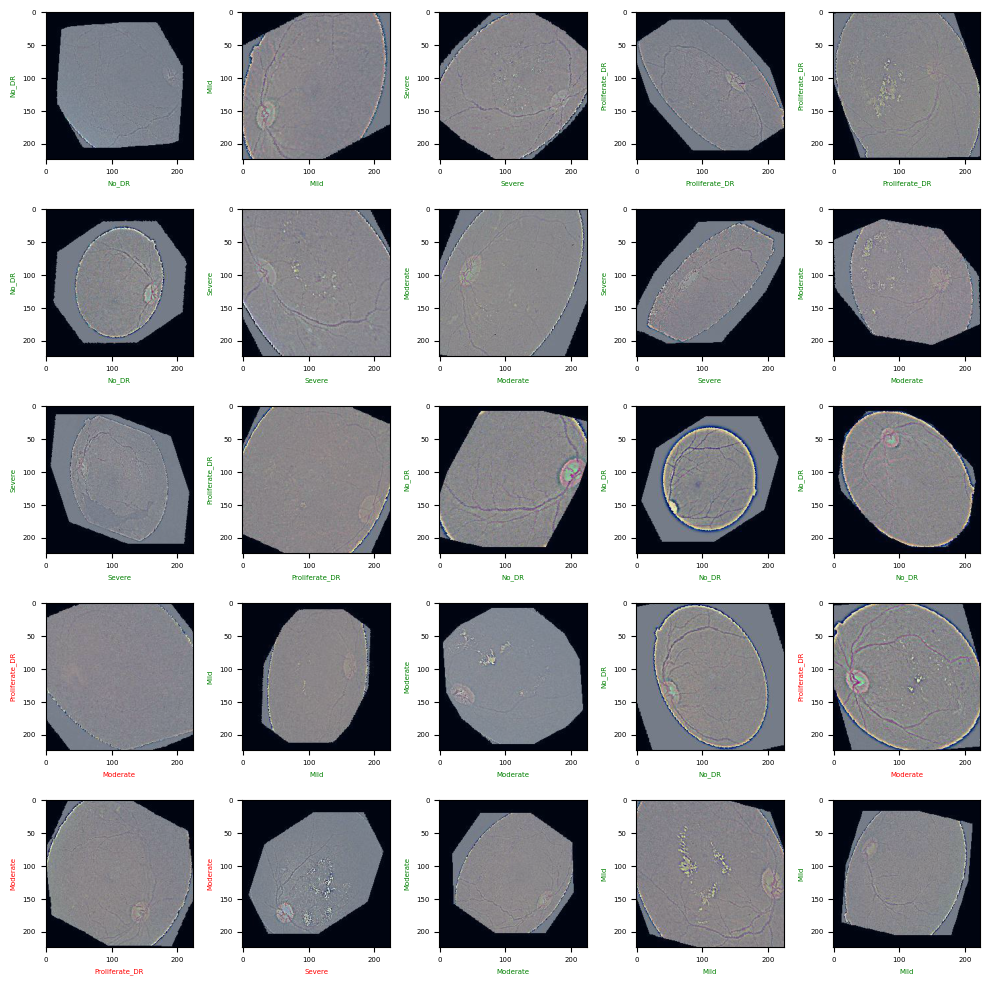

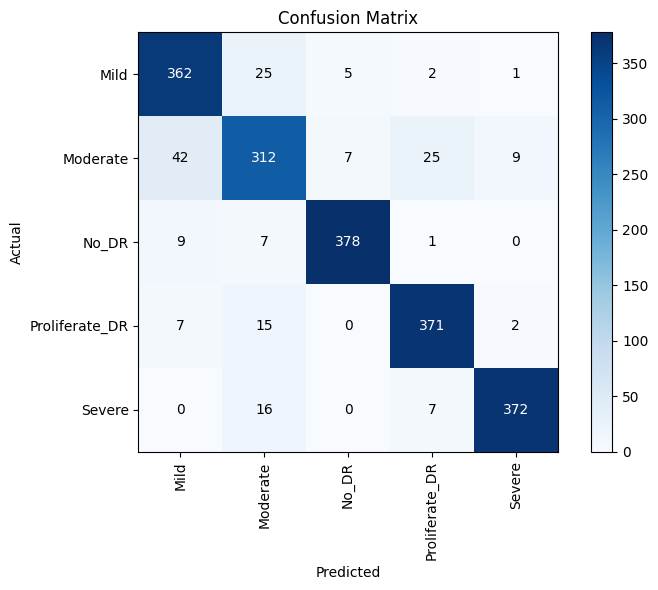



Confusion Matrix:
[[362  25   5   2   1]
 [ 42 312   7  25   9]
 [  9   7 378   1   0]
 [  7  15   0 371   2]
 [  0  16   0   7 372]]
Accuracy: [0.95392405 0.92607595 0.98531646 0.97012658 0.98227848]
Precision: [0.86190476 0.832      0.96923077 0.9137931  0.96875   ]
Recall: [0.9164557  0.78987342 0.95696203 0.93924051 0.94177215]
F1-Score: [0.88834356 0.81038961 0.96305732 0.92634207 0.9550706 ]


In [ ]:
# Resnet
model = ResNet('ResNet', num_classes)
model.to(device)


train_losses, train_accs, valid_accs = train_model(model, train_dl, valid_dl, num_epochs)

print()
print()
print()

# plot loss and validation curves
plot_curves(train_losses, train_accs, valid_accs, num_epochs)

# saving the best weights to be applied to the test dataset
best_model_state = torch.load('/content/ResNet_best_model.pth')
model = ResNet('ResNet', num_classes)
model.load_state_dict(best_model_state)
model.to(device)
model.eval()


# Visualize results
visualize_predictions(model, test_dl, device, test_ds.classes)
print()
print()
generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
confusion_mat = generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
display_confusion_matrix(confusion_mat, test_ds.classes)
print()
print()
generate_confusion_matrix_with_metrics(model, test_dl, device, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Train Loss: tensor(1.2781) Train Accuracy: 0.4503765690376569 Validation Accuracy: 0.5118987341772152
Epoch: 1 Train Loss: tensor(1.0944) Train Accuracy: 0.534560669456067 Validation Accuracy: 0.5524050632911393
Epoch: 2 Train Loss: tensor(1.0195) Train Accuracy: 0.5708786610878661 Validation Accuracy: 0.5949367088607594
Epoch: 3 Train Loss: tensor(0.9591) Train Accuracy: 0.6063598326359833 Validation Accuracy: 0.610126582278481
Epoch: 4 Train Loss: tensor(0.8764) Train Accuracy: 0.6530543933054394 Validation Accuracy: 0.660253164556962
Epoch: 5 Train Loss: tensor(0.8298) Train Accuracy: 0.6652719665271967 Validation Accuracy: 0.6546835443037975
Epoch: 6 Train Loss: tensor(0.7775) Train Accuracy: 0.6930543933054393 Validation Accuracy: 0.68
Epoch: 7 Train Loss: tensor(0.7209) Train Accuracy: 0.7198326359832636 Validation Accuracy: 0.6774683544303798
Epoch: 8 Train Loss: tensor(0.6883) Train Accuracy: 0.7425941422594142 Validation Accuracy: 0.7022784810126582
Epoch: 9 Train Los

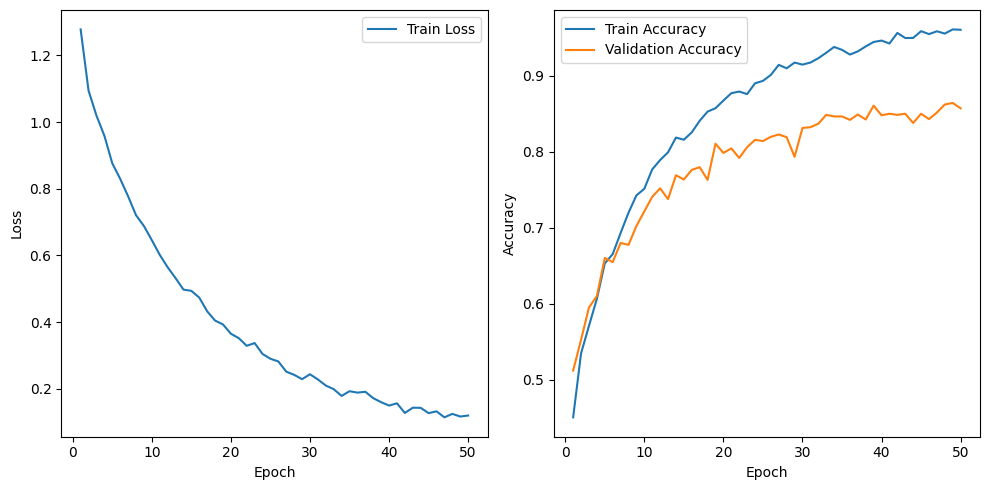

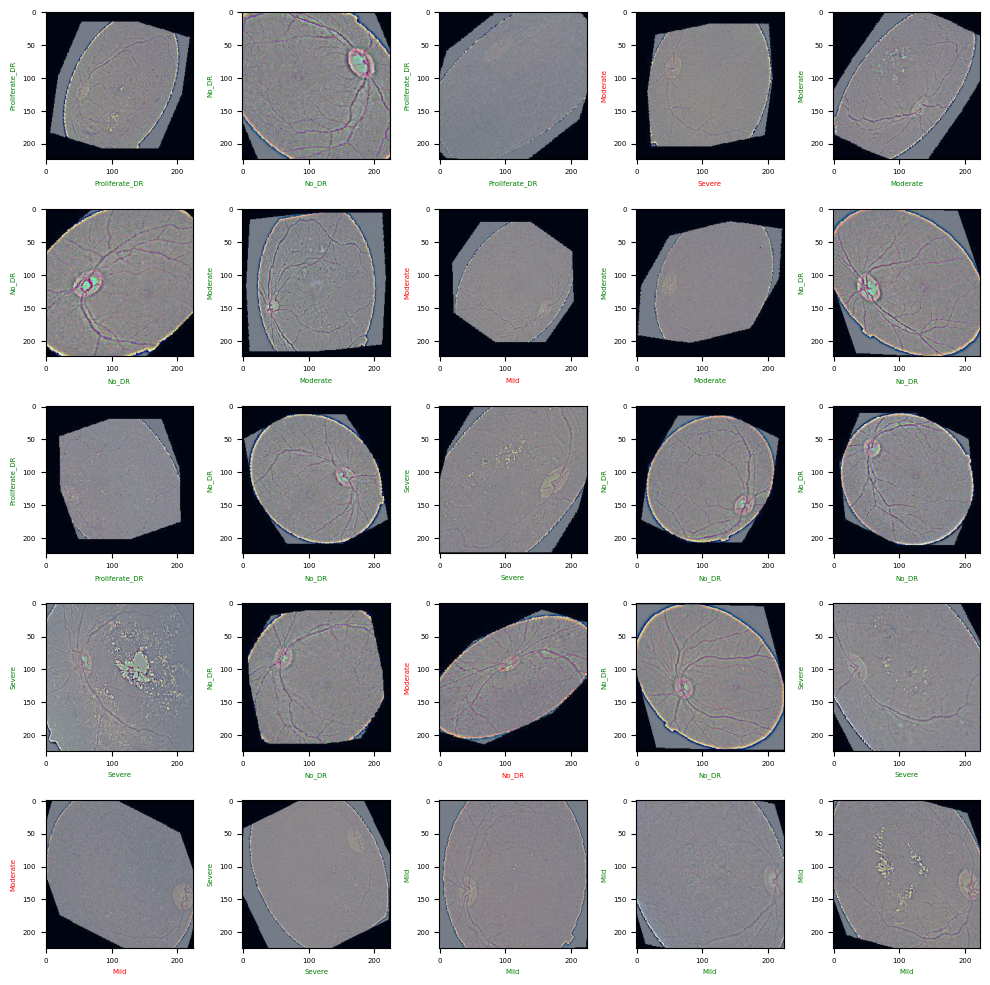

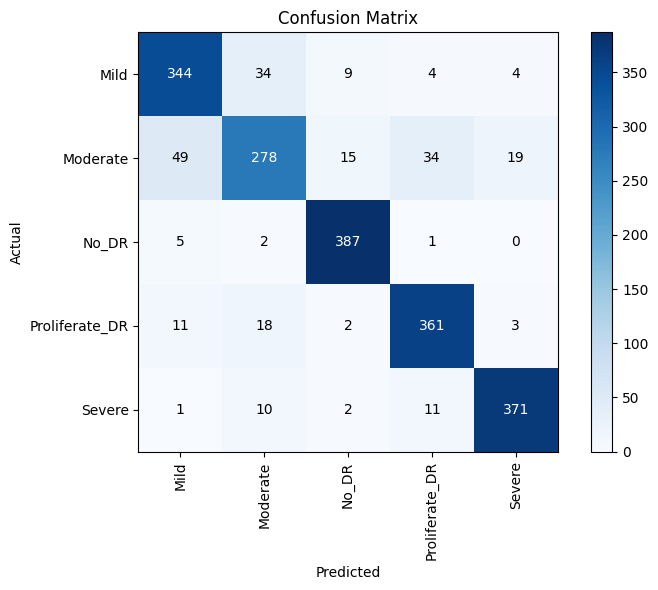



Confusion Matrix:
[[344  34   9   4   4]
 [ 49 278  15  34  19]
 [  5   2 387   1   0]
 [ 11  18   2 361   3]
 [  1  10   2  11 371]]
Accuracy: [0.94075949 0.90835443 0.98177215 0.95746835 0.97468354]
Precision: [0.83902439 0.8128655  0.93253012 0.8783455  0.93450882]
Recall: [0.87088608 0.70379747 0.97974684 0.91392405 0.93924051]
F1-Score: [0.85465839 0.75440977 0.95555556 0.89578164 0.93686869]


In [ ]:
# AlexNet
model = AlexNet('AlexNet', num_classes)
model.to(device)


train_losses, train_accs, valid_accs = train_model(model, train_dl, valid_dl, num_epochs)

print()
print()
print()

# plot loss and validation curves
plot_curves(train_losses, train_accs, valid_accs, num_epochs)

# saving the best weights to be applied to the test dataset
best_model_state = torch.load('/content/AlexNet_best_model.pth')
model = AlexNet('AlexNet', num_classes)
model.load_state_dict(best_model_state)
model.to(device)
model.eval()


# Visualize results
visualize_predictions(model, test_dl, device, test_ds.classes)
print()
print()
generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
confusion_mat = generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
display_confusion_matrix(confusion_mat, test_ds.classes)
print()
print()
generate_confusion_matrix_with_metrics(model, test_dl, device, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Train Loss: tensor(1.2690) Train Accuracy: 0.44 Validation Accuracy: 0.41873417721518985
Epoch: 1 Train Loss: tensor(1.1016) Train Accuracy: 0.5278661087866109 Validation Accuracy: 0.5367088607594936
Epoch: 2 Train Loss: tensor(0.9812) Train Accuracy: 0.5964853556485356 Validation Accuracy: 0.6096202531645569
Epoch: 3 Train Loss: tensor(0.9169) Train Accuracy: 0.6164016736401674 Validation Accuracy: 0.6121518987341772
Epoch: 4 Train Loss: tensor(0.8248) Train Accuracy: 0.6634309623430963 Validation Accuracy: 0.690126582278481
Epoch: 5 Train Loss: tensor(0.7639) Train Accuracy: 0.6947280334728033 Validation Accuracy: 0.6729113924050633
Epoch: 6 Train Loss: tensor(0.7019) Train Accuracy: 0.7245188284518829 Validation Accuracy: 0.7240506329113924
Epoch: 7 Train Loss: tensor(0.6258) Train Accuracy: 0.7514644351464436 Validation Accuracy: 0.7336708860759493
Epoch: 8 Train Loss: tensor(0.5886) Train Accuracy: 0.7777405857740586 Validation Accuracy: 0.7736708860759494
Epoch: 9 Train 

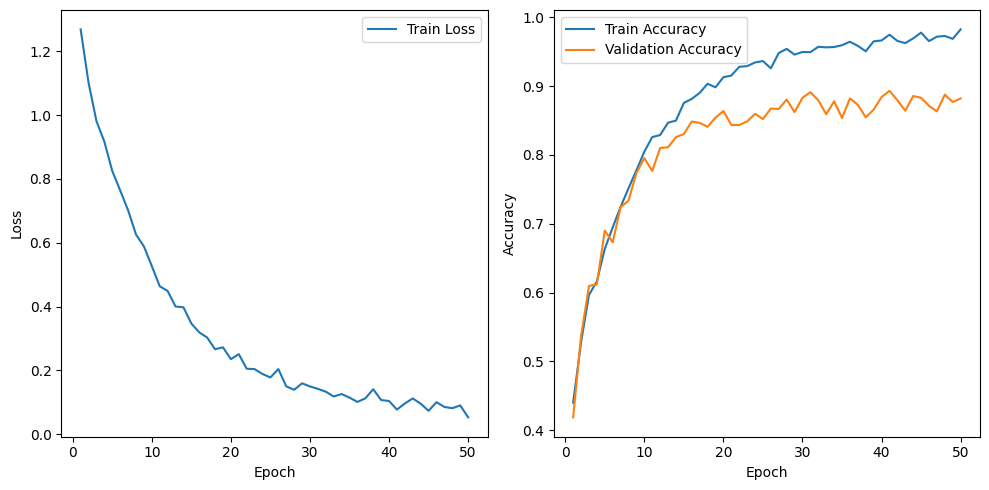

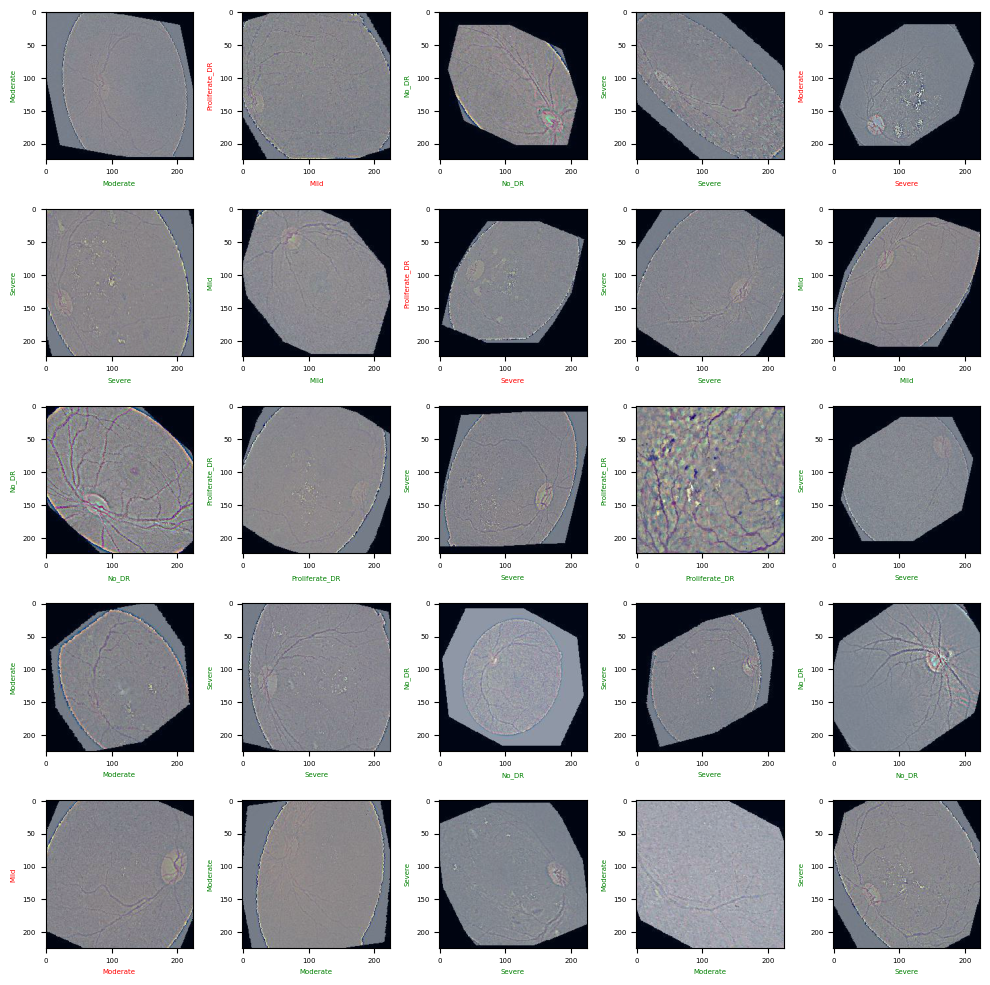

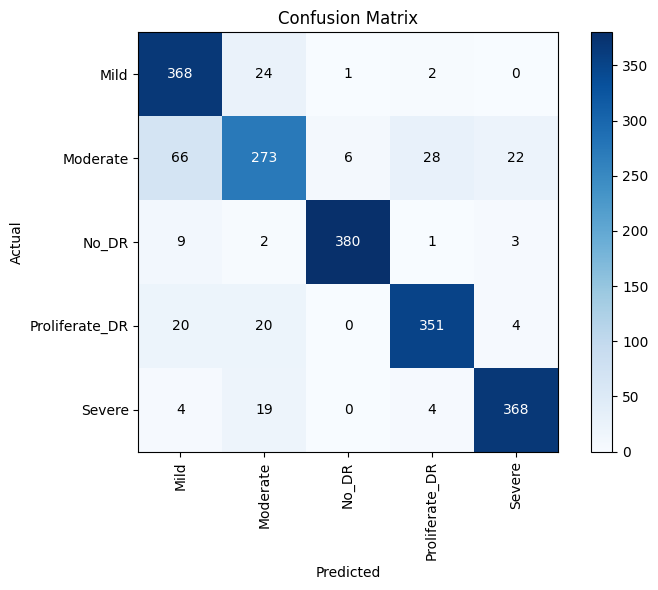



Confusion Matrix:
[[368  24   1   2   0]
 [ 66 273   6  28  22]
 [  9   2 380   1   3]
 [ 20  20   0 351   4]
 [  4  19   0   4 368]]
Accuracy: [0.93620253 0.90531646 0.98886076 0.96       0.97164557]
Precision: [0.78800857 0.80769231 0.98191214 0.90932642 0.92695214]
Recall: [0.93164557 0.69113924 0.96202532 0.88860759 0.93164557]
F1-Score: [0.85382831 0.74488404 0.97186701 0.89884763 0.92929293]


In [ ]:
# VGG
model = VGG('VGG', num_classes)
model.to(device)


train_losses, train_accs, valid_accs = train_model(model, train_dl, valid_dl, num_epochs)


print()
print()
print()

# plot loss and validation curves
plot_curves(train_losses, train_accs, valid_accs, num_epochs)

# saving the best weights to be applied to the test dataset
best_model_state = torch.load('/content/VGG_best_model.pth')
model = VGG('VGG', num_classes)
model.load_state_dict(best_model_state)
model.to(device)
model.eval()

# Visualize results
visualize_predictions(model, test_dl, device, test_ds.classes)
print()
print()
generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
confusion_mat = generate_confusion_matrix(model, test_dl, device, num_classes)
print()
print()
display_confusion_matrix(confusion_mat, test_ds.classes)
print()
print()
generate_confusion_matrix_with_metrics(model, test_dl, device, num_classes)